In [21]:
%matplotlib inline
import glob
from IPython import display
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as pimage
import os
import tensorflow as tf
try:
    import imageio
except (ModuleNotFoundError, ImportError):
    !pip install -q imageio
    import imageio

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# PATH = "/home/adriano/CAP421/lectures/homework13"
PATH = "/content/drive/MyDrive/Doutorado/CAP421/HW_13"

WIDTH, HEIGHT = 64, 64
N_SAMPLES = 1000
CROP_IMG_PATHS = os.path.join(PATH, f"data/PREPROCESSED/CROPPED/{WIDTH}X{HEIGHT}")
MODEL_PATH = os.path.join(PATH, f"MODELS/{WIDTH}X{HEIGHT}")
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)

EPOCHS = 100
NOISE_DIM = 100
BATCH_SIZE = 16
SEED = tf.random.normal([12, NOISE_DIM])
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

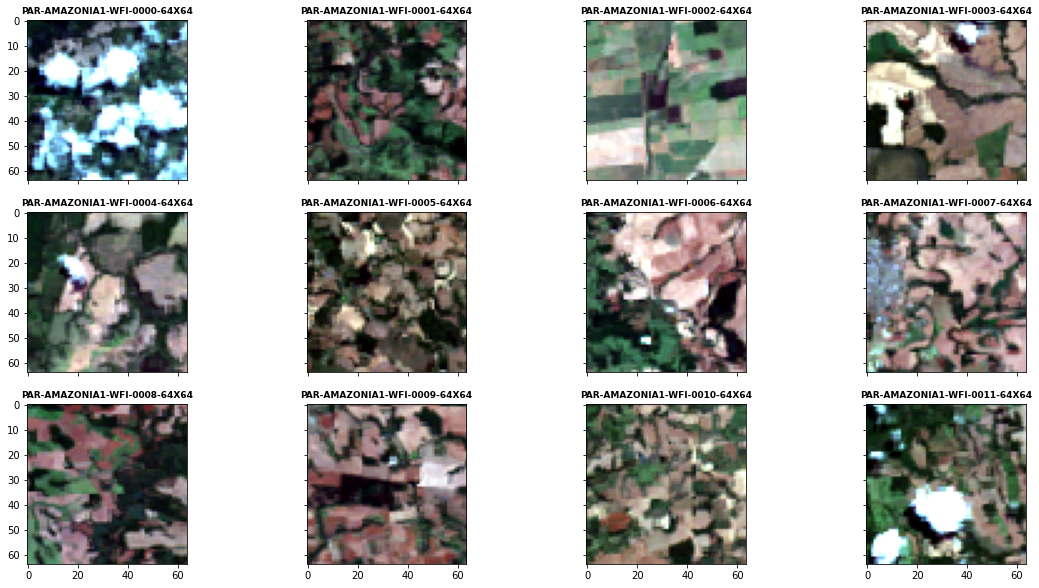

In [4]:
with tf.device('CPU'):
    img_filepaths = sorted([os.path.join(CROP_IMG_PATHS, filename) for filename in os.listdir(CROP_IMG_PATHS)])[:N_SAMPLES]

    fig, ax = plt.subplots(3, 4, figsize=(20, 10), sharex=True, sharey=True)

    for i in range(12):
        row = i//4
        col = i%4
        with pimage.open(img_filepaths[i]) as handle:
            ax[row][col].set_title(img_filepaths[i].split(os.sep)[-1][:-4], fontdict={'size': 9, 'weight': 'bold'})
            ax[row][col].imshow(handle)
            
    fig.subplots_adjust(wspace=0.01)
    plt.show()

In [5]:
with tf.device('CPU'):
    images_all = []
    for filename in img_filepaths:
        with pimage.open(filename) as handle:
            images_all.append(np.asarray(handle))
    images_all = np.array(images_all).astype('float32')
    images_all = (images_all-127.5)/127.5
    images_all.shape

In [6]:
def create_generator_model():
    model = tf.keras.Sequential()
    
    # Input layer
    model.add(tf.keras.layers.Dense(4*4*1024, use_bias=False,  input_shape=(100,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # First layer
    model.add(tf.keras.layers.Reshape((4, 4, 1024)))
    model.add(tf.keras.layers.Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # Second layer
    model.add(tf.keras.layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # Third layer
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # Fourth layer
    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    return model


def create_discriminator_model():
    model = tf.keras.Sequential()
    
    # Input layer
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
      
    # First layer
    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    # Flatten and output discriminator layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
     
    return model


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss+fake_loss

    return total_loss

tf.Tensor([[-0.00060616]], shape=(1, 1), dtype=float32)


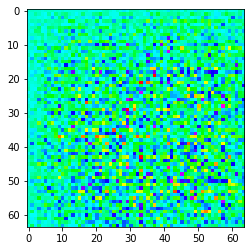

In [7]:
generator = create_generator_model()
discriminator = create_discriminator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

decision = discriminator(generated_image)
plt.imshow(generated_image[0, :, :, 0], cmap ="gist_rainbow")
print(decision)

In [8]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))
  
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
        plt.axis('off')
        
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch), cmap ="gist_rainbow")
    plt.show()


def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # The zip() function returns an iterator of tuples based on the iterable object.
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    
def train(dataset, epochs):  
    for epoch in range(epochs):
        print(f"Epoch: {epoch}")
        start = time.time()
        for i, image_batch in enumerate(dataset):   
            # print(f"\tBatch: {i}")
            train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch+1, SEED)
    
    if (epoch+1)%15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    print (f"Time for epoch {epoch+1} is {time.time()-start} sec")
    
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, SEED)

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(images_all).shuffle(N_SAMPLES).batch(BATCH_SIZE)

In [10]:
checkpoint_dir = f'{MODEL_PATH}'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

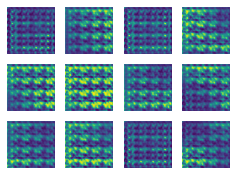

CPU times: user 10min 49s, sys: 29.7 s, total: 11min 19s
Wall time: 28min 28s


In [11]:
%%time
train(train_dataset, EPOCHS)

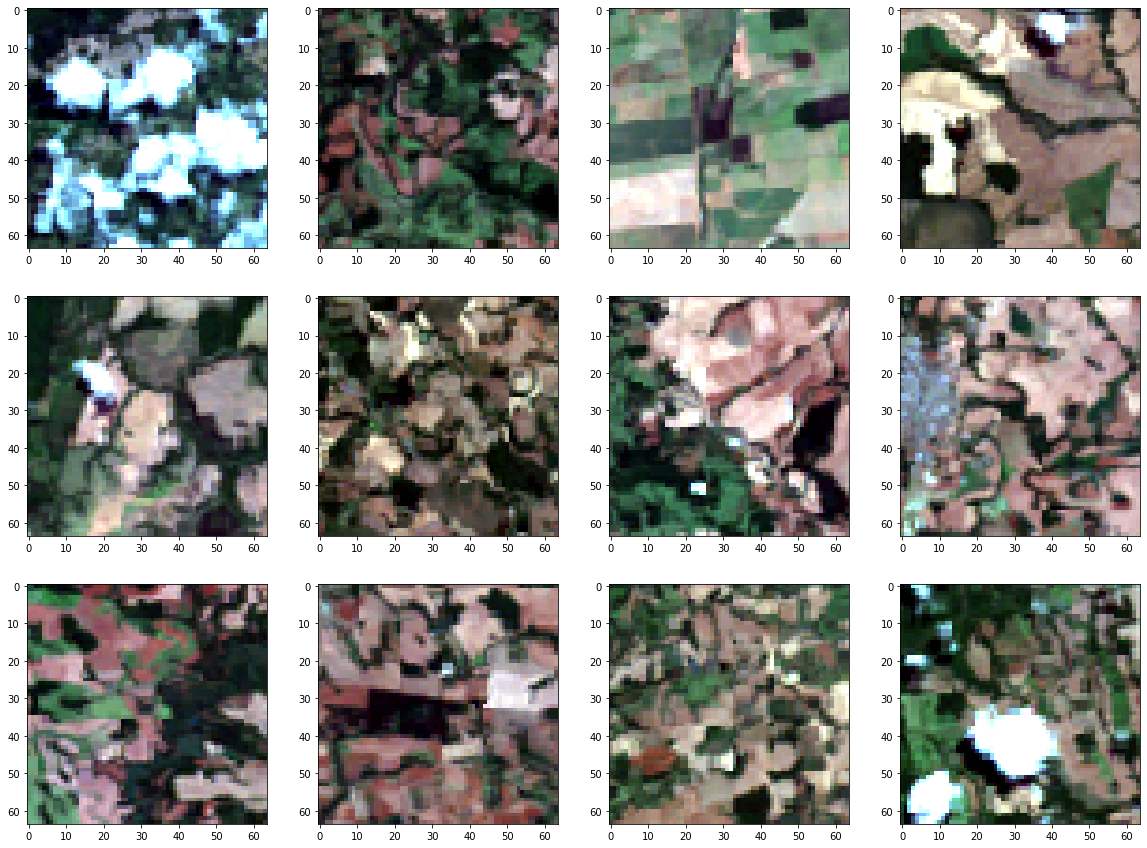

In [13]:
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for i, ax in enumerate(axs.flat):
    x = images_all[i, :, :, :].copy()
    img = (x-x.min())/(x.max()-x.min())
#     img = x
    _ = ax.imshow(img)

(12, 64, 64, 3)


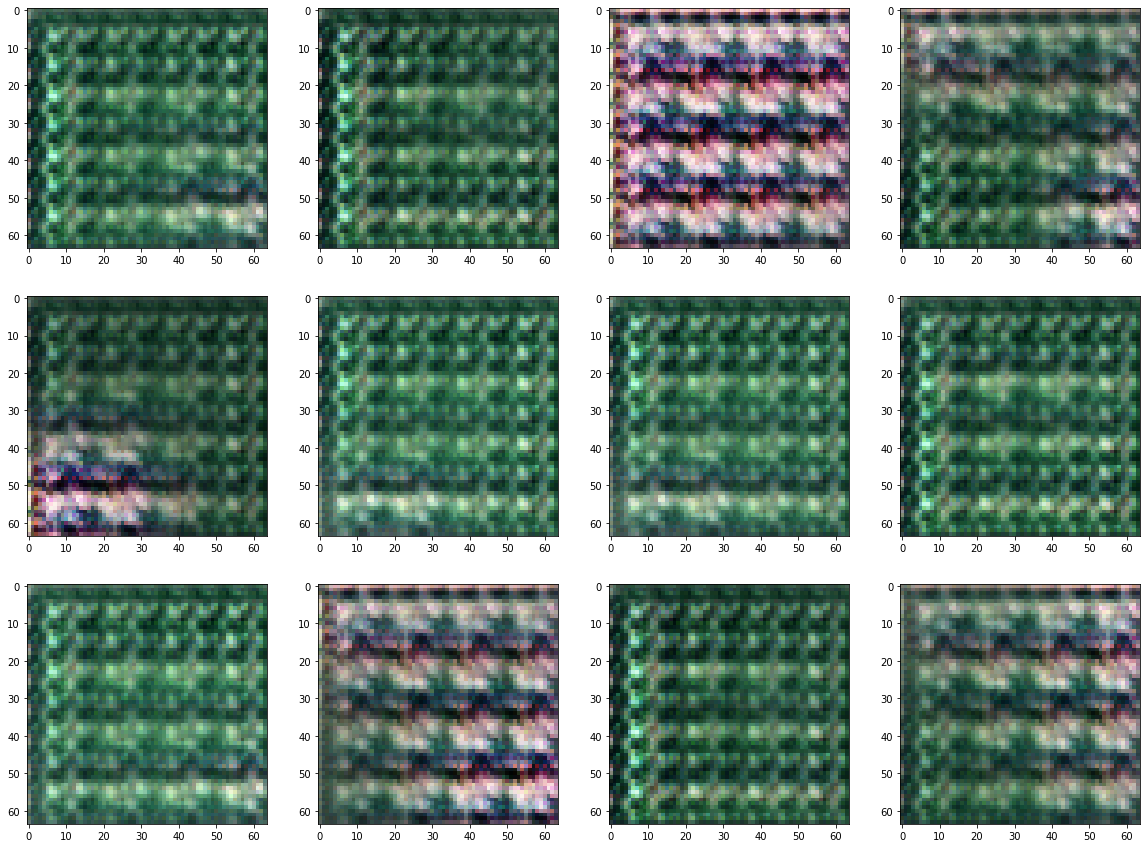

In [14]:
input_noise = tf.random.normal([12, 100])
gen_img = generator(input_noise, training=False)

print(gen_img.shape)
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for i, ax in enumerate(axs.flat):
    x = gen_img[i, :, :, :].numpy().copy()
    img = (x-x.min())/(x.max()-x.min())
    _ = ax.imshow(img)

In [18]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

(12, 64, 64, 3)


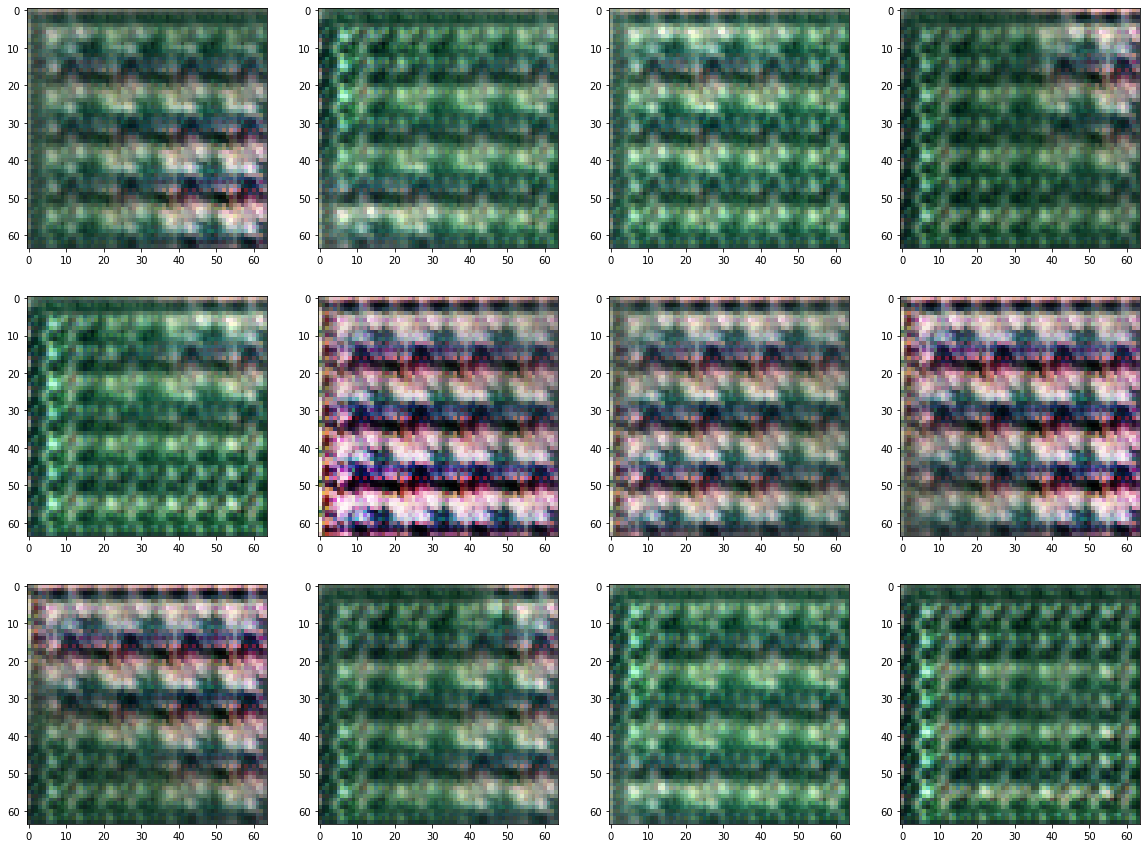

In [19]:
input_noise = tf.random.normal([12, 100])
gen_img = generator(input_noise, training=False)

print(gen_img.shape)
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

for i, ax in enumerate(axs.flat):
    x = gen_img[i, :, :, :].numpy().copy()
    img = (x-x.min())/(x.max()-x.min())
    _ = ax.imshow(img)

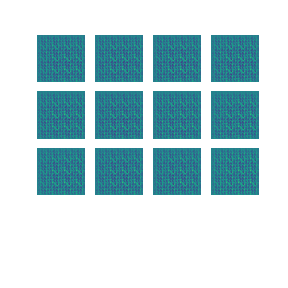

In [33]:
with imageio.get_writer('DCGAN_AMAZONIA1_WFI.gif', mode='I') as writer:
  filenames = glob.glob('image_at_epoch*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
    
# A hack to display the GIF inside this notebook
os.rename('DCGAN_AMAZONIA1_WFI.gif', 'DCGAN_AMAZONIA1_WFI.gif.png')
display.Image(filename="DCGAN_AMAZONIA1_WFI.gif.png")